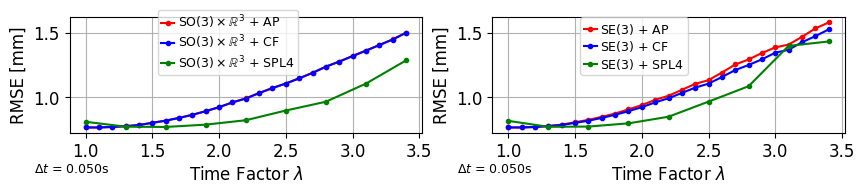

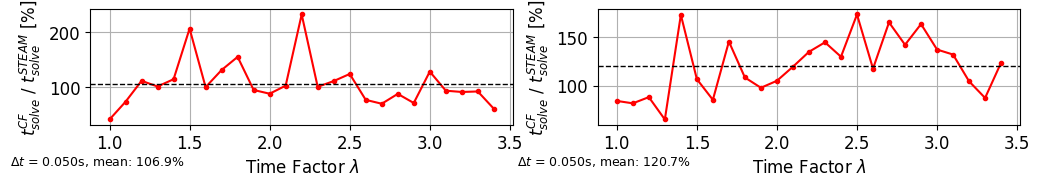

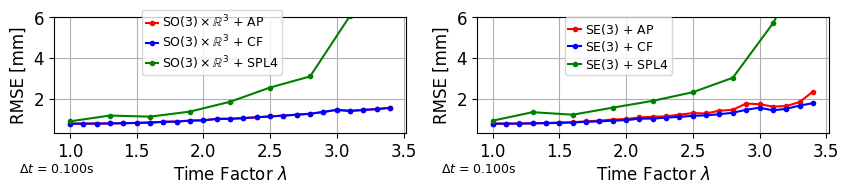

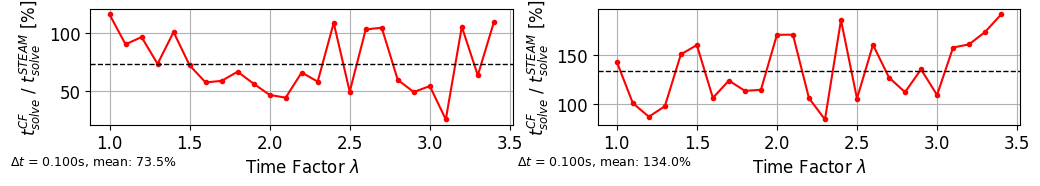

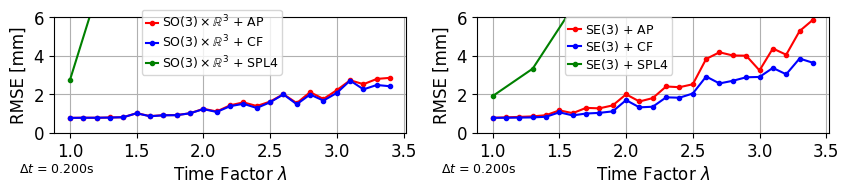

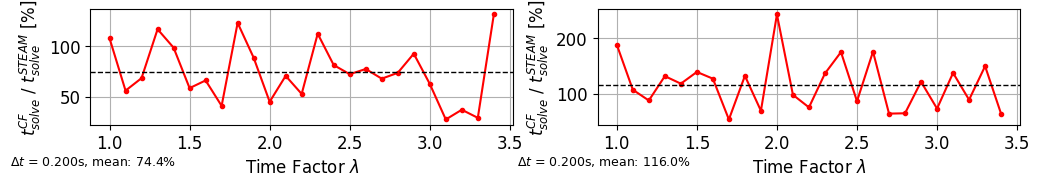

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})  # Sets global font size

log_dir = '/media/tmn/mySataSSD1/Experiments/gptr_v2/logs/vicalib_/'
spline_log_dir = '/home/tmn/Libraries/melodic_ws/lie-spline-experiments/logs/'

# df = pd.read_csv(log_dir + '/logvicalib_backup.csv')
df = pd.read_csv(log_dir + '/vicalib.csv')
df_spline = pd.read_csv(spline_log_dir + '/vicalib.csv')
df_spline = df_spline[df_spline['tskew'] < 3.5]
df_spline['poseres'] = df_spline['spline_type'].apply(lambda x : 'so3xr3' if x == 'split' else 'se3')

# print(df_spline['poseres'])

# Sort value
df.sort_values(by=['tskew', 'dt'], inplace=True)

# dt0 = 0.01
df['m'] = df['dt']
df['n'] = df['tskew']
df['so3xr3_diff'] = df.apply(lambda x : x['so3xr3ap_rmse'] - x['so3xr3cf_rmse'], axis=1)
df['se3_diff'] = df.apply(lambda x : x['se3ap_rmse'] - x['se3cf_rmse'], axis=1)

ns = sorted(list(set(df['n'].tolist())))
ms = sorted(list(set(df['m'].tolist())))

def plotAPCF(ax, dftemp, poseres, m):
    poseresmath = r'$\mathrm{SO}(3)\times\mathbb{R}^3$' if poseres.lower() == 'so3xr3' else '$\mathrm{SE}(3)$'
    ax.plot(dftemp["n"], dftemp[f"{poseres.lower()}ap_rmse"]*1000, marker="o", markersize=3, linestyle="-", color='r', label=f"{poseresmath} + AP")
    ax.plot(dftemp["n"], dftemp[f"{poseres.lower()}cf_rmse"]*1000, marker="o", markersize=3, linestyle="-", color='b', label=f"{poseresmath} + CF")
    
    # df_spline_ = df_spline[ (df_spline['dt'] == m) & (df_spline['N'] == 6) & (df_spline['poseres'] == poseres.lower())]
    # ax.plot(df_spline_["tskew"], df_spline_["rmse"]*1000, marker="o", markersize=3, linestyle="-", color='g', label=f"{poseresmath} + SPL6")
    
    # df_spline_ = df_spline[ (df_spline['dt'] == m) & (df_spline['N'] == 5) & (df_spline['poseres'] == poseres.lower())]
    # ax.plot(df_spline_["tskew"], df_spline_["rmse"]*1000, marker="o", markersize=3, linestyle="-", color='cyan', label=f"{poseresmath} + SPL5")
    
    df_spline_ = df_spline[ (df_spline['dt'] == m) & (df_spline['N'] == 4) & (df_spline['poseres'] == poseres.lower())]
    ax.plot(df_spline_["tskew"], df_spline_["rmse"]*1000, marker="o", markersize=3, linestyle="-", color='green', label=f"{poseresmath} + SPL4")


    ax.grid('on')
    ax.set_xlabel('Time Factor $\lambda$')
    ax.set_ylabel('RMSE [mm]')
    ax.legend(fontsize=9,
              ncol = 1,
              loc=(0.25, 0.5),
              frameon=True,      # Show legend box
              borderaxespad=0.2, # Space between legend and axes
              borderpad=0.3,     # Space inside the legend box
              handletextpad=0.3, # Space between legend handle and text
              labelspacing=0.2,  # Vertical space between labels
              handlelength=1.0   # Length of the legend line
             )
    
def plotAPCFTslv(ax, dftemp, poseres, m):
    
    dftemp_ = dftemp.copy()
    dftemp_['tslv_ratio'] = dftemp_.apply(lambda x: x[f"{poseres.lower()}cf_tslv"]/ x[f"{poseres.lower()}ap_tslv"] * 100, axis=1)
    ax.plot(dftemp_["n"], dftemp_['tslv_ratio'], marker=".", linestyle="-", color='r')
    
    mean = dftemp_['tslv_ratio'].mean()
    ax.axhline(y=mean, color="black", linestyle="--", linewidth=1)
    
    # ax.text(0.95, ax.get_ylim()[-1]*0.05 + ax.get_ylim()[0]*0.95, f'mean: {mean:.1f}%\n $\Delta t$ = {m:.3f}s \n')    
    ax.grid('on')
    ax.set_xlabel('Time Factor $\lambda$')
    ax.set_ylabel(r'$t_{solve}^{CF}$ / $t_{solve}^{STEAM}$ [%]')
    # ax.legend()
    
    return mean

for m in ms:
    
    # if m not in [0.05, 0.1]:
    #     continue
     
    dftemp = df[(df['m'] == m) & (df['n'] <= 3.4)]
    fig, ax = plt.subplots(1, 2, figsize=(10, 1.5))
    plotAPCF(ax[0], dftemp, 'SO3xR3', m)
    plotAPCF(ax[1], dftemp, 'SE3', m)
    
    ylims = ax[0].get_ylim() + ax[1].get_ylim()
    ymin, ymax = min(ylims), max(ylims)
    
    ax[0].set_ylim([max(0, ymin), min(ymax, 6)])
    ax[1].set_ylim([max(0, ymin), min(ymax, 6)])
    
    # ax[0].set_ylim([ymin, ymax])
    # ax[1].set_ylim([ymin, ymax])
    # ymean = ymin + (ymax - ymin)*0.45
    
    ax[0].text(-0.1, -0.350,  f'$\Delta t$ = {m:.3f}s', transform=ax[0].transAxes, fontsize=9)
    ax[1].text(-0.1, -0.350,  f'$\Delta t$ = {m:.3f}s', transform=ax[1].transAxes, fontsize=9)

    # ax[0].set_xticks(np.arange(1, 25, 5))
    # ax[1].set_xticks(np.arange(1, 25, 5))
    
    plt.show()
    
    # fig.tight_layout()
    fig.savefig(log_dir + f'vi_so3xr3_dt_{int(m*1000):03d}.jpg', bbox_inches='tight', dpi=300)
    
    # Plot the computational time
    fig, ax = plt.subplots(1, 2, figsize=(12, 1.5))
    mean0 = plotAPCFTslv(ax[0], dftemp, 'SO3xR3', m)
    mean1 = plotAPCFTslv(ax[1], dftemp, 'SE3', m)
     
    ax[0].text(-0.19, -0.350, f'$\Delta t$ = {m:.3f}s, mean: {mean0:.1f}%', transform=ax[0].transAxes, fontsize=9)
    ax[1].text(-0.19, -0.350, f'$\Delta t$ = {m:.3f}s, mean: {mean1:.1f}%', transform=ax[1].transAxes, fontsize=9)
    # ax[0].text(-0.19, -0.355, f'mean: {mean0:.1f}%', transform=ax[0].transAxes, fontsize=9)
    # ax[1].text(-0.19, -0.355, f'mean: {mean1:.1f}%', transform=ax[1].transAxes, fontsize=9)
    
    # fig.tight_layout()
    fig.savefig(log_dir + f'vi_so3xr3_tslv_dt_{int(m*1000):03d}.jpg', bbox_inches='tight', dpi=300)
